In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import importlib
import os, sys
sys.path.append(os.path.abspath('../../visualization'))
from plotters import plot_gp, plot_gpkf, plot_gpkf_space_time
from kernel import KernelFactory, Kernel

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from params import Params
from gpkf import Gpkf
from generateSyntheticData import generateSyntheticData
#from plotters import plot_gp, plot_gp_example, plot_residuals

In [2]:
df = pd.read_csv('../../data/mergedData.csv')
df.set_index('Timestamp', inplace=True)
df.index = pd.to_datetime(df.index)
df.index = np.around(df.index.to_julian_date() * 24 * 60)
df.index = df.index - df.index[0]

In [3]:
center_df = df[[col for col in df.columns if 'Pos1' in col and 'DO' in col]] #.dropna(axis = 0, how = 'all')
#center_df = df['Pos1m3DO'].dropna(axis=0)
#center_df

In [4]:
def start_train(df):
    locations = np.array([3,6,9,12]).conj().T
    params = Params(df, locations, 'fornes')
    model = Gpkf(params)

    #F, Y, noiseVar = generateSyntheticData(params.data)
    print('Formatting data')
    
    F = df.loc[params.data['timeInstants']].to_numpy().T
    Y = df.to_numpy().T[params.data['spaceLocsMeasIdx']]
    Y_mean = np.nanmean(Y, axis=0)
    Y_std = np.nanstd(Y, axis=0)
    Y = (Y - Y_mean) / Y_std
    
    noiseVar = (params.data['noiseStd'] * np.abs(Y))**2
    noiseVar[np.isnan(noiseVar)] = np.inf
    noiseVar[Y==0] = params.data['noiseStd']**2
    
    #F, Y, noiseVar = generateSyntheticData(params.data)
    #Y_mean = Y.mean(axis=0)
    #Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)
    
    # Optimize parameters
    print('Optimizing parameters (log-marginal)')
    model.optimize(Y, noiseVar, params.optimizer_restarts)
    
    # GPKF estimate
    print('GPKF estimation')
    posteriorMean, posteriorCov, logMarginal = model.estimation(Y, noiseVar)

    #GPKF prediction
    print('GPKF prediction')
    predictedMean, predictedCov = model.prediction(Y, noiseVar)
    
    #plot_gpkf(params.data['spaceLocsMeas'], params.data['spaceLocsMeasIdx'], F[:,-1][params.data['spaceLocsMeasIdx']], posteriorMean[:,-1], posteriorCov[:,:,-1])
    plot_gpkf(params.data['spaceLocsPred'], [3,6,9,12], F[:,-1], predictedMean[:,-1] + Y_mean[-1], predictedCov[:,:,-1])
    #plot_gpkf(np.arange(0, params.data['spaceLocsPredIdx'].size), np.arange(0,params.data['spaceLocsPredIdx'].size), F[:,-1][params.data['spaceLocsPredIdx']], predictedMean[:,-1], predictedCov[:,:,-1])

    return model

In [5]:
#model = start_train(center_df)
depthLocations = np.array([3,6,9,12]).conj().T
params = Params(center_df, depthLocations, 'fornes')

#F, Y, noiseVar = generateSyntheticData(params.data)
print('Formatting data')

F = center_df.loc[params.data['timeInstants']].to_numpy().T
Y = center_df.to_numpy().T[params.data['spaceLocsMeasIdx']]

factory = KernelFactory()
kernel_time = factory.get_kernel('matern32', {'scale' :12.238893, 'std': 23.9659459, 'frequency':750})
kernel_space = factory.get_kernel('gaussian', {'scale' : 0.01 , 'std': 1, 'frequency':750})

model = Gpkf(params, Y, kernel_time, kernel_space, normalize_y = True, n_restarts = 0)

Using fornes dataset
Formatting data


In [6]:
# Optimize parameters
print('Optimizing parameters (log-marginal)')
#model.optimize()
#Y_mean = np.nanmean(Y)
#Y_mean

Optimizing parameters (log-marginal)


In [7]:
"""# GPKF estimate
print('GPKF estimation')
posteriorMean, posteriorCov, logMarginal = model.estimation(prediction= False)

#GPKF prediction
print('GPKF prediction')
predictedMean, predictedCov = model.prediction()"""

"# GPKF estimate\nprint('GPKF estimation')\nposteriorMean, posteriorCov, logMarginal = model.estimation(prediction= False)\n\n#GPKF prediction\nprint('GPKF prediction')\npredictedMean, predictedCov = model.prediction()"

In [8]:
"""
plot_gpkf_space_time(params, F, posteriorMean, posteriorCov, predictedMean, predictedCov, 1000, 7)
plt.savefig('test'+'.png')
samples = np.random.multivariate_normal(posteriorMean[0,:].ravel(), posteriorCov[0,:,:], 1)
plot_gpkf(params.data['TimeInstants'], [], [], posteriorMean[0, :], posteriorCov[0,0,:], samples=samples)"""

"\nplot_gpkf_space_time(params, F, posteriorMean, posteriorCov, predictedMean, predictedCov, 1000, 7)\nplt.savefig('test'+'.png')\nsamples = np.random.multivariate_normal(posteriorMean[0,:].ravel(), posteriorCov[0,:,:], 1)\nplot_gpkf(params.data['TimeInstants'], [], [], posteriorMean[0, :], posteriorCov[0,0,:], samples=samples)"

# 3D

In [181]:
df_do = df[[col for col in df.columns if 'DO' in col]].dropna(axis = 0, how = 'all')
locations = df_do.iloc[0]
locations = locations.astype('object')
center = 30
for col in locations.index:
    depth = int(re.search('m\d+', col).group()[1:])  # Get sensor depth
    if 'Pos1' in col:
        locations[col] = np.array([center, depth, center])
    elif 'Pos4' in col:
        locations[col] = np.array([center +21, depth, center])
    elif 'Pos5' in col:
        locations[col] = np.array([center, depth, center+21])
    elif 'Pos6' in col:
        locations[col] = np.array([center - 21, depth, center])
    elif 'Pos7' in col:
        locations[col] = np.array([center, depth, center-21])
    elif 'Pos12' in col:
        locations[col] = np.array([center, depth, center])
    elif 'Pos21' in col:
        locations[col] = np.array([center-20, depth, center])
    elif 'Pos22' in col:
        locations[col] = np.array([center-27, depth, center])
    elif 'Pos23' in col:
        locations[col] = np.array([center-21, depth, center])
    elif 'Pos31' in col:
        locations[col] = np.array([center + 2, depth, center + 20])
    elif 'Pos32' in col:
        locations[col] = np.array([center, depth, center+27])
    elif col == 'Outsidem3DO':
        locations[col] = np.array([center-30, depth, center])
    elif col =='SouthOutsidem3DO':
        locations[col] = np.array([center, depth, center+27])
    elif col =='Northm3DO':
        locations[col] = np.array([center, depth, center+19])
    elif col =='Southm3DO':
        locations[col] = np.array([center, depth, center-19])
        
# Symmetric standardization of location inputs
locations_values = np.stack(locations.values)
scaler = preprocessing.StandardScaler().fit(locations_values)
locations_values = scaler.transform(locations_values)

#xx, yy, zz = np.meshgrid(np.arange(0,66,6), 3, np.arange(0,66,6))
#xx, yy, zz = np.meshgrid(30, np.arange(1,14,1), 30)
xx, yy, zz = np.meshgrid(center, 3, np.arange(0,60,1))
locations_pred = scaler.transform(np.column_stack([xx.flatten(), yy.flatten(), zz.flatten()]))

In [237]:
params = Params(df_do, locations_values, 'fornes')

print('Formatting data')

F = df_do.loc[params.data['timeInstants']].to_numpy().T
Y = df_do.to_numpy().T[params.data['spaceLocsMeasIdx']]

print('Initializing Model')
# create time kernel
factory = KernelFactory()
#kernel_time = factory.get_kernel('matern32', {'scale' : 0.01, 'std': 0.1, 'frequency':750}) # 0.6 and 0.0001
kernel_time = factory.get_kernel('matern32', {'scale' :12.638893, 'std': 13.19, 'frequency':750})

# create space kernel
kernel_space = factory.get_kernel('gaussian', {'scale' : 8.57 , 'std': 0.14, 'frequency':750})
#kernel_space = factory.get_kernel('gaussian', {'scale' : 0.01 , 'std': 1, 'frequency':750})
model = Gpkf(params, Y, kernel_time, kernel_space, normalize_y = True, n_restarts = 0)

Using fornes dataset
Formatting data
Initializing Model


In [55]:
#model.optimize()
locations.values[0]

array([30,  3, 30])

In [238]:
# GPKF estimate
#print('GPKF estimation')
#posteriorMean, posteriorCov, logMarginal = model.estimation(prediction= False)

#GPKF prediction
print('GPKF prediction')
predictedMean, predictedCov = model.prediction(locations_pred)

print(model)

GPKF prediction


C:\Users\moesk\Documents\Masteroppgave\gaussianProcess\GPKF\gpkf.py:259: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  l2 = innovation.conj().T @ np.linalg.lstsq(innovVar, innovation)[0]


[56810.08725729]
Time kernel: {'scale': 12.638893, 'std': 13.19, 'frequency': 750}
Space kernel: {'scale': 8.57, 'std': 0.14, 'frequency': 750}


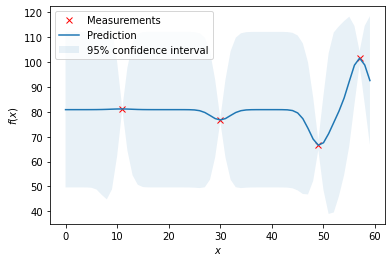

In [239]:
centerLocs = locations_values[:4]
timeStamp = 1000
#plot_gpkf(np.arange(1,14,1), np.array([3,6,9,12]), Y[:4, timeStamp], predictedMean[:,timeStamp], predictedCov[:,:,timeStamp], **{'linestyle' : 'None', 'marker': 'x'})

midLoc = np.array([i for i in locations.values if i[1] == 3 and i[0] ==center])
midLocIdx = np.array([i for loc in scaler.transform(midLoc) for i, v in enumerate(locations_values) if (v==loc).all()])
plot_gpkf(np.arange(0,60,1), midLoc[:,2], Y[midLocIdx, timeStamp], predictedMean[:,timeStamp], predictedCov[:,:,timeStamp], **{'linestyle' : 'None', 'marker': 'x'})

In [189]:
Y[midLocIdx, timeStamp]
midLoc

array([[30,  3, 30],
       [30,  3, 51],
       [30,  3,  9],
       [30,  3, 57],
       [30,  3, 11],
       [30,  3, 49]])

In [ ]:
X = np.ones((22, 3)) * 30
X[:,0] = np.linspace(0,60, 60)
X[:,1] = 3
number_of_functions = 1

sig = kernel_space.sampled(X, X)
mu = np.zeros(22) * 10
print(posteriorMean.shape)
samp = np.random.multivariate_normal(posteriorMean[:,1000].ravel(), posteriorCov[:,:,1000], number_of_functions)

ax = sns.heatmap(samp, xticklabels=1, yticklabels = 1, cmap='viridis', cbar_kws=dict(pad=0.01, aspect=10))

plt.figure(figsize=(6, 4), dpi=100)
for i in range(number_of_functions):
    plt.plot(X[:,0], samp[i], linestyle='-', marker='o', markersize=3)
plt.axhline(y=0.0, color='black', linestyle='-')
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)

In [ ]:
posteriorCov[:,:,1000].ravel().shape
posteriorMean[:,1000]

In [ ]:
m3Indexes = np.array([key for key, value in enumerate(locations.values) if value[1]==3])
m3Pos = np.array([value[[0,2]] for key, value in enumerate(locations.values) if value[1]==3])
vals = np.zeros(shape=(11,11))
for key,value in enumerate(params.data['spaceLocsPred']):
    vals[int(value[0]/6),int(value[2]/6)] = predictedMean[key,2500]

ax = sns.heatmap(vals, xticklabels=1, yticklabels = 1, cmap='viridis', cbar_kws=dict(pad=0.01, aspect=10))
ax.invert_yaxis()

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
xx, yy = np.meshgrid(np.arange(0,11), np.arange(0,11))
ax.plot_surface(xx, yy, vals, cmap='viridis',
                       linewidth=0, antialiased=False)

In [ ]:
predictedMean[:,1000]
#params.data['spaceLocsMeas']